In [1]:
import gzip
import os

import numpy as np

from six.moves import urllib

import torch as t

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY = "data"

# Params for MNIST
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 10000  # Size of the validation set.

# Download MNIST data
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.exists(DATA_DIRECTORY):
        os.mkdir(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.stat(filepath).st_size
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath


# Extract the images
def extract_data(filename, num_images, norm_shift=False, norm_scale=True):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    #print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        if norm_shift:
            data = data - (PIXEL_DEPTH / 2.0)
        if norm_scale:
            data = data / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = np.reshape(data, [num_images, -1])
    return data

# Extract the labels
def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    #print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
        one_hot_encoding[np.arange(num_labels_data),labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

# Prepare MNISt data
def prepare_MNIST_data(n_train=10_000, n_val=10000, n_test=10000, 
                       use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False):
    # Get the data.
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

    # Extract it into np arrays.
    X_train = extract_data(train_data_filename, n_train+n_val, use_norm_shift, use_norm_scale)
    y_train = extract_labels(train_labels_filename, n_train+n_val)
    X_test = extract_data(test_data_filename, n_test, use_norm_shift, use_norm_scale)
    y_test = extract_labels(test_labels_filename, n_test)

    # Generate a validation set.
    X_val = X_train[:n_val, :]
    y_val = y_train[:n_val,:]

    X_train = X_train[n_val:n_val+n_train, :]
    y_train = y_train[n_val:n_val+n_train,:]

    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    assert len(X_train)==len(y_train)
    assert len(X_val)==len(y_val)
    assert len(X_test)==len(y_test)

    data = {'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test}
    return data

def get_dataloader(X, y, batch_size):
    X_tensor = t.tensor(X, dtype=t.float32)
    y_tensor = t.tensor(y, dtype=t.int64)
    dataset = t.utils.data.TensorDataset(X_tensor, y_tensor)
    dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torchvision
from torch import nn
from torch import optim
from torch.nn import functional as F
def divide_no_nan(a, b):
    """
    a/b where the resulted NaN or Inf are replaced by 0.
    """
    result = a / b
    result[result != result] = .0
    result[result == np.inf] = .0
    return result


class WeightNormConstrainer(object):

    def __init__(self, norm):
        self.norm = norm

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            wn = t.norm(w, p=2, dim=1).detach()
            ind = t.gt(wn, self.norm)
            div = (divide_no_nan(wn, self.norm) * ind) + (1 * t.logical_not(ind))
            div = div.unsqueeze_(1)
            w.div_(div)

class _LeNet(nn.Module):
    def __init__(self, layers):
        super(_LeNet, self).__init__()
        self.input_layer = nn.Sequential(*layers['input_layer'])
        self.hidden_layers = nn.Sequential(*layers['hidden_layers'])
        self.output_layer = nn.Sequential(*layers['output_layer'])

    def layer_features(self, x):
        input_layer = self.input_layer(x)
        hidden = self.hidden_layers(input_layer)
        logits = self.output_layer(hidden)
        layer_features = {'input_layer': input_layer.data.cpu().numpy(),
                          'hidden': hidden.data.cpu().numpy(),
                          'logits': logits.data.cpu().numpy()}
        return layer_features

    def get_intermediate(self, x):
        
        conv1 = self.input_layer[0](x)
        conv1 = self.input_layer[1](conv1)

        pool1 = self.input_layer(x)
        pool1 = self.hidden_layers[0](pool1)

        return conv1, pool1

    def forward(self, x):
        input_layer = self.input_layer(x)
        hidden = self.hidden_layers(input_layer)
        logits = self.output_layer(hidden)
        return logits


class Reshape(t.nn.Module):
  def forward(self, x):
      return x.view(-1,1,28,28)

class LeNet(object):
    def __init__(self, params):
        
        super().__init__()
        self.params = params
        self.device = t.device('cuda' if t.cuda.is_available() else 'cpu')
        self.activations = {'logistic': nn.Sigmoid(), 'relu': nn.ReLU()}
        self.pooling ={'avg':nn.AvgPool2d(kernel_size=2, stride=2),'max':nn.MaxPool2d(kernel_size=2, stride=2)}
        # Instantiate model
        t.manual_seed(self.params['random_seed'])
        np.random.seed(self.params['random_seed'])
        layers = self._initialize_network()
        self.model = _LeNet(layers).to(self.device)
        self.layers = layers
    def _initialize_network(self):
    	# TODO: complete this function
        # Input
        input_layers = [Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2),self.activations[self.params['activation']]]
        if self.params['pooling'] == 'no':
          hidden_layers = [nn.Conv2d(6, 16, kernel_size=5), self.activations[self.params['activation']],
                           nn.Flatten(), nn.Linear(16 * 24 * 24, 120), self.activations[self.params['activation']], nn.Linear(120, 84), self.activations[self.params['activation']]]        
        else:
          hidden_layers = [self.pooling[self.params['pooling']], nn.Conv2d(6, 16, kernel_size=5), self.activations[self.params['activation']], self.pooling[self.params['pooling']],
                           nn.Flatten(), nn.Linear(16 * 5 * 5, 120), self.activations[self.params['activation']], nn.Linear(120, 84), self.activations[self.params['activation']]]
        output_layer =  [nn.Linear(84, 10)]                
        layers = {'input_layer': input_layers,
          'hidden_layers': hidden_layers,
          'output_layer': output_layer}
        return layers
    
    def evaluate_accuracy(self, dataloader):
        self.model.eval()
        with t.no_grad():
            n_correct = 0
            n_samples = 0
            for batch in iter(dataloader):
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)
                
                logits = self.model(batch_x)
                y_hat = t.argmax(logits, dim=1)
                correct = t.sum(y_hat==batch_y)

                n_correct += correct.data.cpu().numpy()
                n_samples += len(batch_x)
        accuracy = (n_correct/n_samples) * 100
        self.model.train()
        return accuracy

    def evaluate_cross_entropy(self, dataloader):
        loss = nn.CrossEntropyLoss()
        losses = []
        self.model.eval()
        with t.no_grad():
            for batch in iter(dataloader):
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)

                logits = self.model(batch_x)
                batch_loss = loss(logits, batch_y)
                losses.append(batch_loss.cpu().data.numpy())
        cross_entropy = np.mean(losses)
        self.model.train()
        return cross_entropy
    
    def adjust_lr(self, optimizer, lr_decay):
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * lr_decay
        
    def adjust_momentum(self, optimizer, step, momentum_change_steps,
                        initial_momentum, final_momentum):
        mcs = momentum_change_steps
        s = min(step, mcs)
        momentum = (initial_momentum) * ((mcs-s)/mcs) + \
                   (final_momentum) * (s/mcs)
        for param_group in optimizer.param_groups:
            param_group['momentum'] = momentum

    def get_filters(self):
        filters = self.model.input_layer[1].weight.data.cpu().numpy()
        #filters = filters.reshape(self.params['hidden_layers'][0], 28, 28)
        return filters

    def fit(self, insample_dataloader, outsample_dataloader):        
        # Instantiate optimization tools
        loss = nn.CrossEntropyLoss()        
        optimizer = optim.SGD([{'params': self.model.input_layer.parameters()},
                               {'params': self.model.hidden_layers.parameters()},
                               {'params': self.model.output_layer.parameters(),
                                'weight_decay': self.params['output_l2_decay']}],
                               lr=self.params['initial_lr'],
                               momentum=self.params['initial_momentum'])
        
        constrainer = WeightNormConstrainer(norm=self.params['weight_norm'])

        # Initialize counters and trajectories
        step = 0
        epoch = 0
        metric_trajectories = {'step':  [],
                               'epoch':  [],
                               'insample_accuracy': [],
                               'outsample_accuracy': [],
                               'insample_cross_entropy': [],
                               'outsample_cross_entropy': []
                               }

        print('\n'+'='*36+' Fitting LeNet '+'='*36)
        while step <= self.params['iterations']:

            # Train
            epoch += 1
            self.model.train()
            for batch in iter(insample_dataloader):
                step+=1
                if step > self.params['iterations']:
                    continue
                                
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)
                
                optimizer.zero_grad()

                # TODO: make predictions, compute the loss and backward propagation
                logits = self.model(batch_x)
                training_loss = loss(logits, batch_y)
                training_loss.backward()

                t.nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                optimizer.step()

                # Evaluate metrics
                if (step % params['display_step'] == 0):
                    in_cross_entropy   = self.evaluate_cross_entropy(insample_dataloader)
                    out_cross_entropy  = self.evaluate_cross_entropy(outsample_dataloader)
                    in_accuracy        = self.evaluate_accuracy(insample_dataloader)
                    out_accuracy       = self.evaluate_accuracy(outsample_dataloader)

                    print('Epoch:', '%d,' % epoch,
                          'Step:', '%d,' % step,
                          'In Loss: {:.7f},'.format(in_cross_entropy),
                          'Out Loss: {:.7f},'.format(out_cross_entropy),
                          'In Acc: {:03.3f},'.format(in_accuracy),
                          'Out Acc: {:03.3f}'.format(out_accuracy))
                    
                    metric_trajectories['insample_cross_entropy'].append(in_cross_entropy)
                    metric_trajectories['outsample_cross_entropy'].append(out_cross_entropy)
                    metric_trajectories['insample_accuracy'].append(in_accuracy)
                    metric_trajectories['outsample_accuracy'].append(out_accuracy)

                # Update optimizer learning rate
                if step % self.params['adjust_lr_step'] == 0:
                    self.adjust_lr(optimizer=optimizer, lr_decay=self.params['lr_decay'])
                
                # Update optimizer momentum
                if step % self.params['adjust_momentum_step'] == 0 and \
                    step < self.params['momentum_change_steps']:
                    self.adjust_momentum(optimizer=optimizer, step=step,
                                         momentum_change_steps=self.params['momentum_change_steps'],
                                         initial_momentum=self.params['initial_momentum'],
                                         final_momentum=self.params['final_momentum'])
              
                # Constraint max_norm of weights
                if self.params['apply_weight_norm'] and \
                  (step % self.params['adjust_norm_step'] == 0):
                    self.model.apply(constrainer)

        # Store trajectories
        print('\n'+'='*35+' Finished Train '+'='*35)
        self.trajectories = metric_trajectories

In [ ]:
params = {'model': 'lenet',
          'display_step': 250, 
          'batch_size': 1024,
          'iterations': 30_000,
          'initial_lr': 0.05,
          'lr_decay': 0.5,
          'adjust_lr_step': 10_000,
          'initial_momentum': 0.5,
          'final_momentum': 0.95,
          'momentum_change_steps': 20_000,
          'adjust_momentum_step': 2_000,
          'apply_weight_norm': True,
          'weight_norm': 3.5,
          'adjust_norm_step': 5_000,
          'output_l2_decay': 0.001,
          'pooling': 'no',
          'activation':'relu',
          'random_seed': 42}

data = prepare_MNIST_data(n_train=20_000, n_val=10_000, n_test=5_000,
                              use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False)
X_train, y_train, X_val, y_val, _, _ = data.values()
insample_dataloader = get_dataloader(X_train, y_train, batch_size=params['batch_size'])
outsample_dataloader = get_dataloader(X_val, y_val, batch_size=params['batch_size'])


clf_no = LeNet(params)
start = time.time()
clf_no.fit(insample_dataloader, outsample_dataloader)
end = time.time()
time_no = end - start



params['pooling']='avg'
clf_avg = LeNet(params)
start = time.time()
clf_avg.fit(insample_dataloader, outsample_dataloader)
end = time.time()
time_avg = end - start


params['pooling']='max'
clf_max = LeNet(params)
start = time.time()
clf_max.fit(insample_dataloader, outsample_dataloader)
end = time.time()
time_max = end - start

(b) The results are shown in the table below. 

M_no takes longer to train because there are more parameters for training.

Model | training acc | testing acc | training time
--- | --- | --- | ---
M_no | 100 | 97.57 | 696.5
M_avg | 100 | 97.88 | 479.2
M_max | 100 | 98.09 | 484.3

(c) Train and test loss


```
# This is formatted as code
```



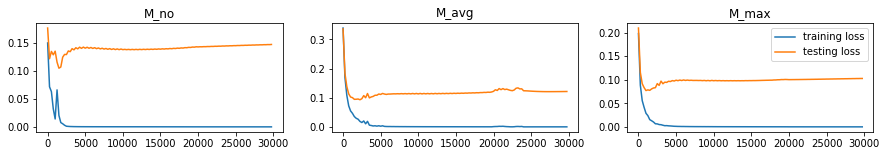

In [24]:
fig, ax = plt.subplots(1,3,figsize=(15,2))
keys = ['insample_cross_entropy', 'outsample_cross_entropy']
clfs = [clf_no,clf_avg,clf_max]
model_names = ['M_no','M_avg','M_max']
for i in range(len(clfs)):
  ax[i].plot(np.arange(len(clfs[i].trajectories[keys[0]]))*params['display_step'], clfs[i].trajectories[keys[0]],label='training loss')
  ax[i].plot(np.arange(len(clfs[i].trajectories[keys[0]]))*params['display_step'], clfs[i].trajectories[keys[1]],label='testing loss')
  ax[i].set_title(model_names[i])
ax[-1].legend()
plt.show()

(d) Train and test acc


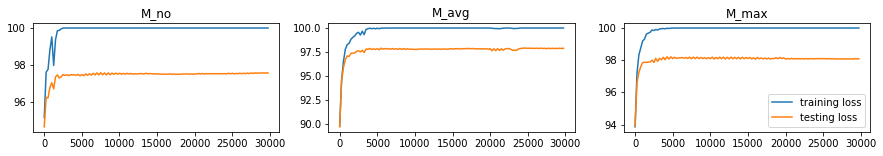

In [25]:
fig, ax = plt.subplots(1,3,figsize=(15,2))
keys = ['insample_accuracy', 'outsample_accuracy']
clfs = [clf_no,clf_avg,clf_max]
model_names = ['M_no','M_avg','M_max']
for i in range(len(clfs)):
  ax[i].plot(np.arange(len(clfs[i].trajectories[keys[0]]))*params['display_step'], clfs[i].trajectories[keys[0]],label='training loss')
  ax[i].plot(np.arange(len(clfs[i].trajectories[keys[0]]))*params['display_step'], clfs[i].trajectories[keys[1]],label='testing loss')
  ax[i].set_title(model_names[i])
ax[-1].legend()
plt.show()

(e) visualization of intermediate layers


From original to first conv: the filters detected different edges of the digit

From first conv to first pool: max pooling downsampled the output of the first conv layer.

In [29]:
model = clf_max.model
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
X_train = extract_data(train_data_filename, 1, 1, 1)
x = t.tensor(X_train[0])
intermediate_layers = model.get_intermediate(x.to(clf_max.device))
conv1 = intermediate_layers[0].data.cpu().numpy()
pool1 = intermediate_layers[1].data.cpu().numpy()

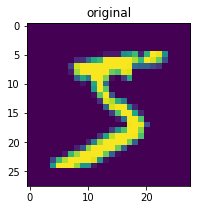

In [40]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(x.data.cpu().numpy().reshape([28,-1]))
ax.set_title('original')
plt.show()

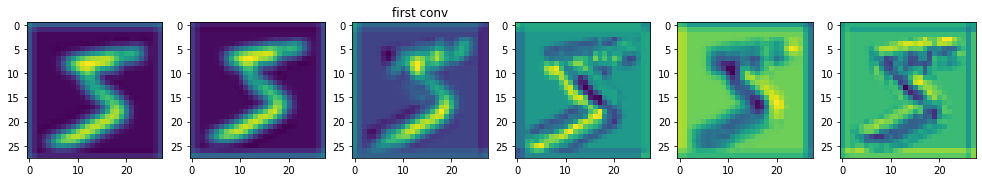

In [46]:
fig, ax = plt.subplots(1,6,figsize=(17,3))
for i in range(6):#
  ax[i].imshow(conv1[0,i])
ax[2].set_title('first conv')
plt.show()

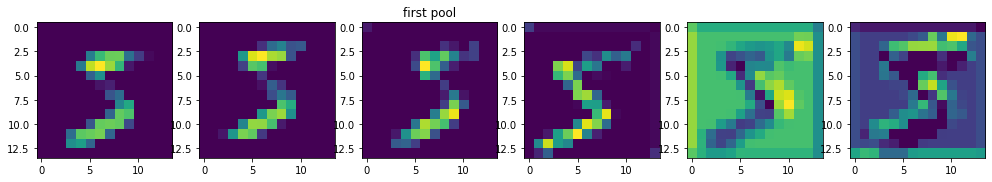

In [45]:
fig, ax = plt.subplots(1,6,figsize=(17,3))
for i in range(6):#
  ax[i].imshow(pool1[0,i])
ax[2].set_title('first pool')
plt.show()